<a href="https://colab.research.google.com/github/surajn581/covid19_detection/blob/master/lung_segmentation_and_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
base_path = '/content/drive/My Drive/Colab Notebooks/covid19_detection/Trash/'

In [2]:
train_path = "/content/drive/My Drive/Colab Notebooks/covid19_detection/train_data"
test_path = "/content/drive/My Drive/Colab Notebooks/covid19_detection/test_data"

In [3]:
!pip install pydicom
!pip install einops

In [4]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from einops import rearrange, reduce  # pip install einops (amazing lib!)
import cv2
from itertools import starmap
import os
import random
import tensorflow as tf

%matplotlib inline

In [5]:
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
# Configure a few matplotlib parameters
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['image.interpolation'] = 'bilinear'

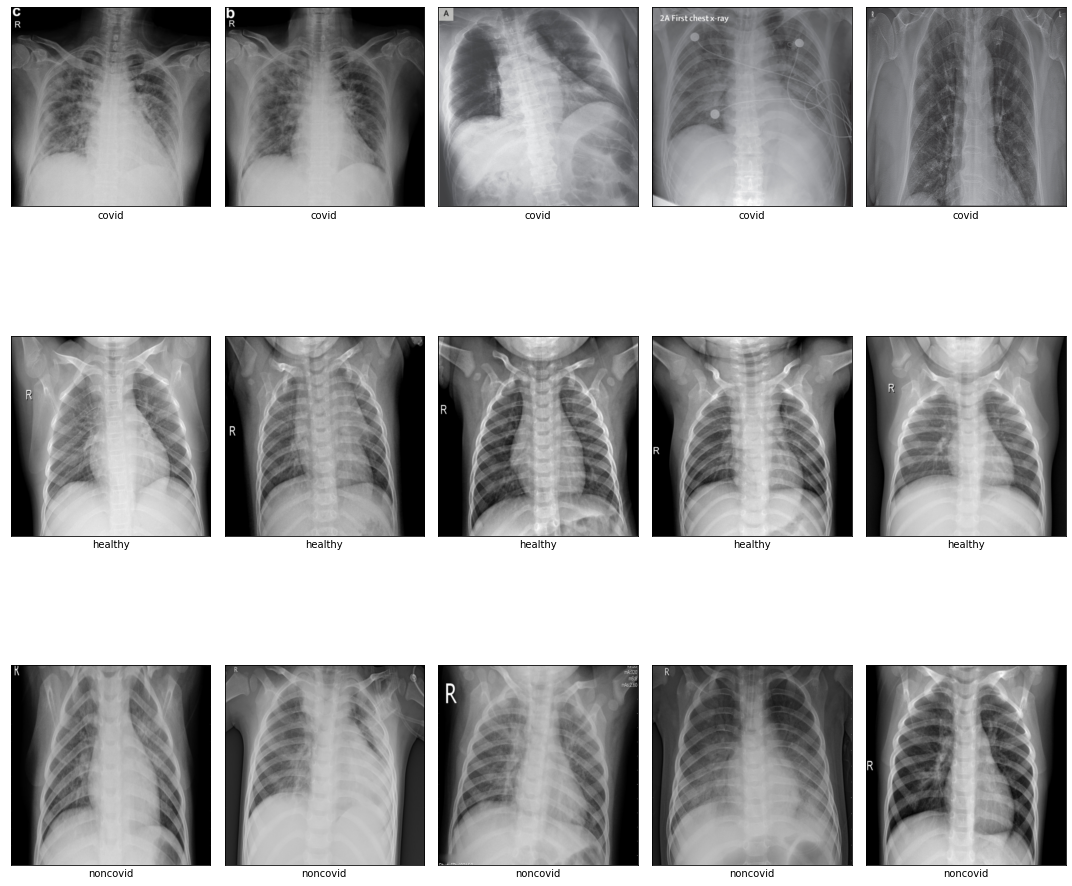

In [7]:
# Randomly view 5 images in each category
labels = ['covid', 'healthy', 'noncovid']

fig, axs = plt.subplots(len(labels), 5, figsize = (15, 15))


class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(train_path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])

fig.tight_layout()

In [23]:
class_path = os.path.join(base_path,'sample_images')
all_images = os.listdir(class_path)
sample_images = random.sample(all_images, 10)

In [36]:
def extract_image(fname):
    image = cv2.imread(str(fname),0)
    return image

fnames = list(Path(base_path+'sample_images').glob('*.png'))
imgs = np.array(list(map(extract_image, fnames)))
imgs.shape

(10, 1024, 1024)

In [60]:
def plot_images(imgs, c):
  fig, axs = plt.subplots(2, 5, figsize = (15, 15))

  for i in range(2):
    for j, image in enumerate(imgs[5*i:5*(i+1)]):
      
      img = image

      axs[i, j].imshow(img)
      axs[i, j].set(xlabel = c, xticks = [], yticks = [])

  plt.tight_layout()

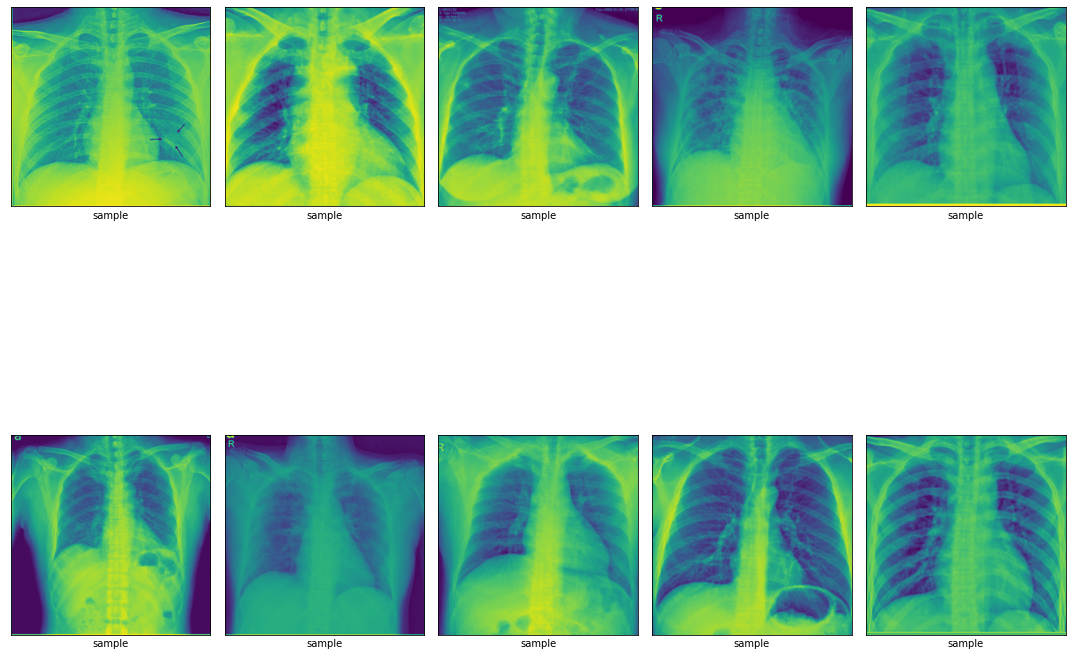

In [61]:
plot_images(imgs, 'sample')

In [8]:
from keras.models import load_model

In [18]:
unet = load_model(base_path+"unet_lung_seg.hdf5", compile=False)

In [83]:
def prepare_input(img, width=512, height=512):
    '''
    Prepare image to be feed into model, according to definitions made by trained model
    '''
    # Resize
    x = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
    
    # Normalize
    x = np.float32(x) / 255.
    
    # Add channel axis
    x = x[..., np.newaxis]
    
    return x

def rescale_output(img, width=1024, height=1024):
    '''
    Prepare image to be feed into model, according to definitions made by trained model
    '''
    # Resize
    x = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
    
    # # Normalize
    # x = np.float32(x) / 255.
    
    # # Add channel axis
    # x = x[..., np.newaxis]
    
    return x

In [56]:
X = np.array(list(map(prepare_input, imgs)))
print(X.shape)

(10, 512, 512, 1)

In [84]:
y_pred = unet.predict(X)
print(y_pred.shape)
outputs = y_pred.reshape((y_pred.shape[0], y_pred.shape[1], y_pred.shape[2]))
print(outputs.shape)

outputs = np.array(list(map(rescale_output, outputs)))

(10, 512, 512, 1)
(10, 512, 512)


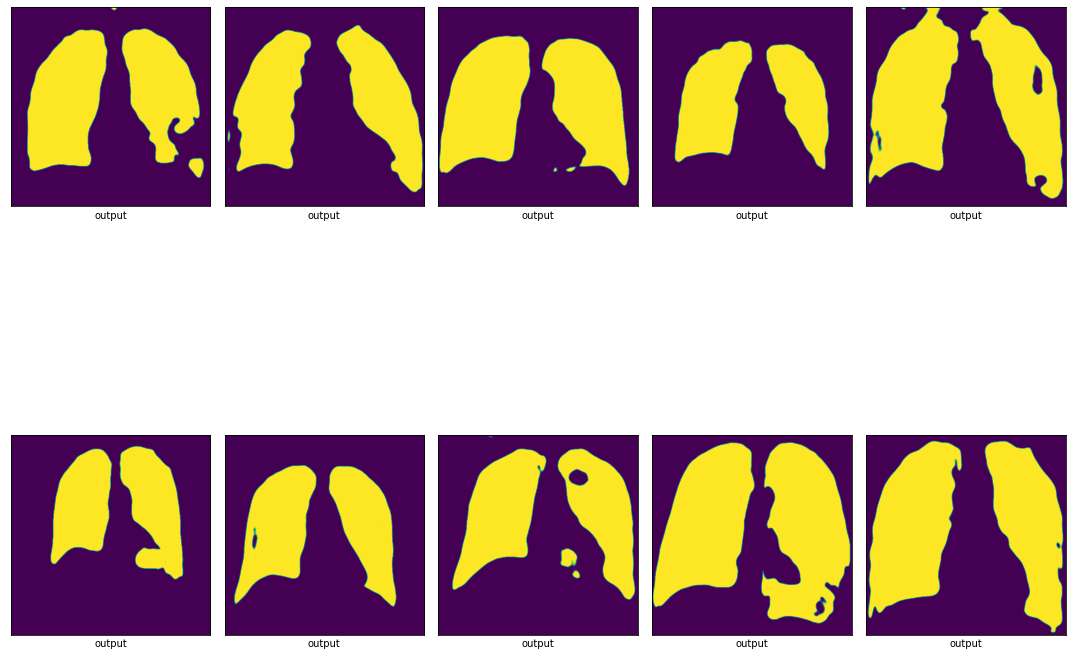

In [85]:
plot_images(outputs, 'output')

In [86]:
#A helper function to display 2 images side by side
def visualize(original, output):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Ouptut image')
  plt.imshow(output)

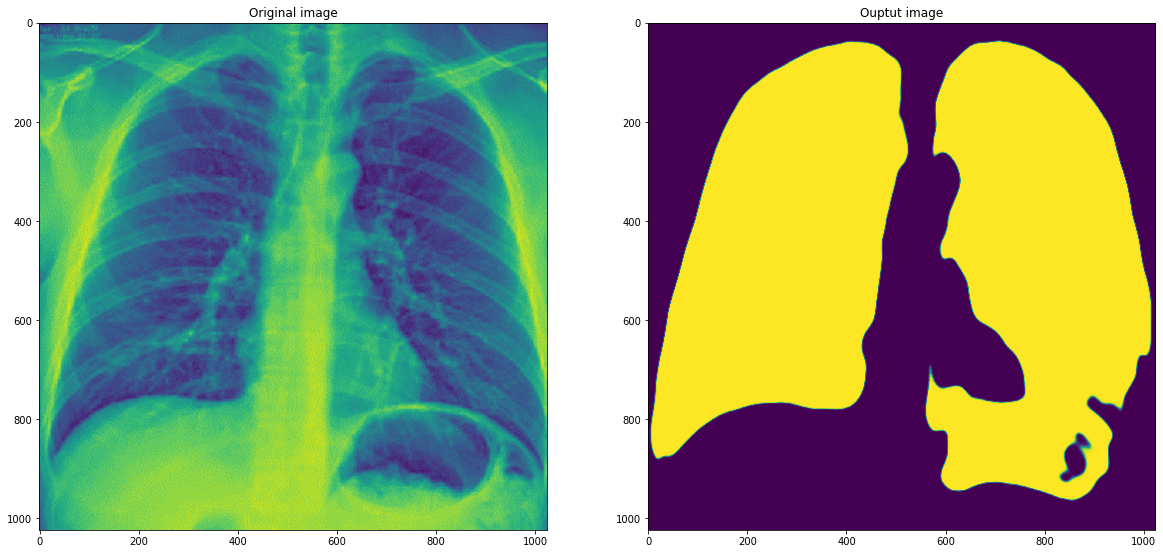

In [87]:
i = 8
visualize(imgs[i], outputs[i])

In [88]:
from scipy import ndimage

# Declare structure used in morphotology opening
morph_structure = np.ones((11, 11))

def crop_segmentation(mask, *others, width=512, height=512, extra_space=0.1):
    '''
    Crop using `mask` as input. `others` are optional arguments that will be croped using `mask`
    as reference.
    '''
    # Binarize mask
    mask_bin = np.squeeze(mask) > 0.5
    
    # Use morphology opening to reduce small structures detected.
    mask_bin = ndimage.morphology.binary_opening(mask_bin, morph_structure)
    
    # This is one of the trickest part: will label each structure and keep only the 3 biggest ones.
    # We assume that these three ones will include the background and two lungs
    mask_bin_label, n_labels = ndimage.label(mask_bin, np.ones((3, 3), dtype=np.uint8))
    used_labels = np.argsort(-np.bincount(mask_bin_label.ravel()))[:3]

    # Remove from mask other objects that are not top-3
    mask_bin &= np.in1d(mask_bin_label.reshape(-1), used_labels).reshape(mask_bin.shape)
    
    # Squeeze horizontal and vertical dimention to find where mask begins and ends
    mask_bin_hor = mask_bin.any(axis=0)
    mask_bin_ver = mask_bin.any(axis=1)

    # Find index of first and last positive pixel
    xmin, xmax = np.argmax(mask_bin_hor), len(mask_bin_hor)-np.argmax(mask_bin_hor[::-1])
    ymin, ymax = np.argmax(mask_bin_ver), len(mask_bin_ver)-np.argmax(mask_bin_ver[::-1])
    
    # Add extra space
    xextra = int((xmax-xmin) * extra_space)
    yextra = int((ymax-ymin) * extra_space)
    xmin -= xextra
    xmax += xextra
    ymin -= yextra
    ymax += yextra
    
    # We will use affine transform to crop image. It will deal with padding image if necessary
    # Note: `pts` will follow a L shape: top left, bottom left and bottom right
    # For details see: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html#affine-transformation
    pts1 = np.float32([[xmin, ymin], [xmin, ymax], [xmax, ymax]])
    pts2 = np.float32([[0, 0], [0, height], [width, height]])
    M = cv2.getAffineTransform(pts1, pts2)

    # Crop mask
    mask_crop = cv2.warpAffine(mask, M, (height, width), flags=cv2.INTER_AREA, borderValue=0)
    
    if len(others) > 0:
        # Crop others
        others_crop = tuple(cv2.warpAffine(np.squeeze(other), M, (height, width), flags=cv2.INTER_AREA, borderValue=0) for other in others)
        
        return (mask_crop, ) + others_crop
    else:
        return mask_crop

In [89]:
y_crop, X_crop = map(np.array, zip(*starmap(crop_segmentation, zip(y_pred, X))))

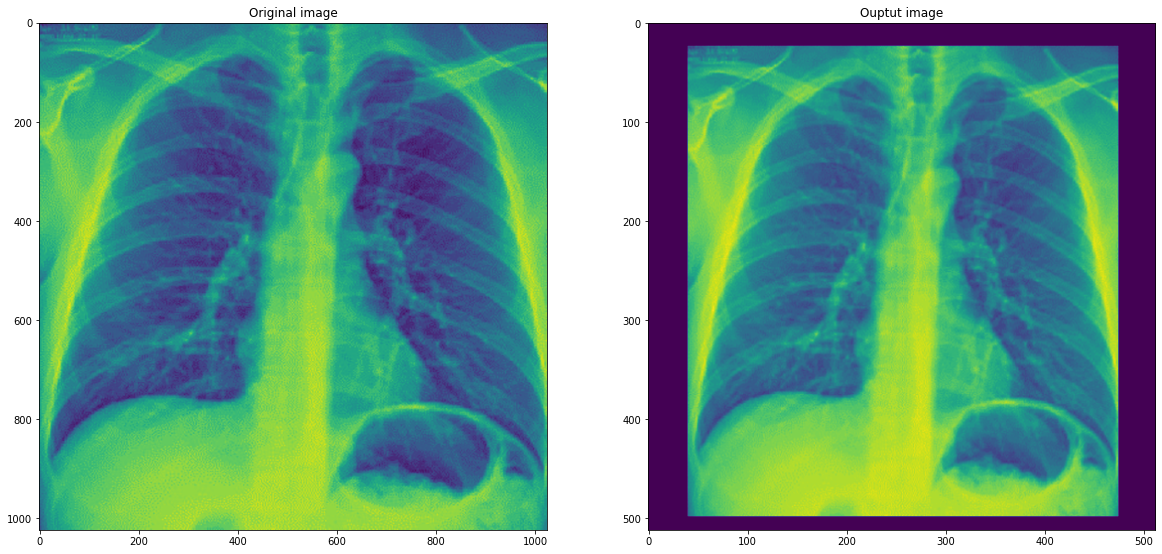

In [90]:
i = 8
visualize(imgs[i], X_crop[i])

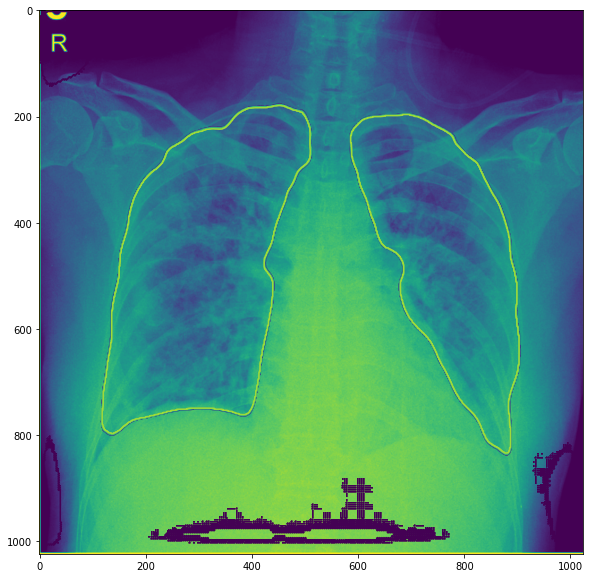

In [98]:
i = 3
plt.imshow(imgs[i])
plt.contour(outputs[i])
plt.show()